# Top-quark pair example analysis

In [1]:
# The user specifies if running notebook on GoogleColab or locally
UseGoogleColab = True

In [2]:
if UseGoogleColab:
    from google.colab import drive
    drive.mount('/content/drive')
    USERDIR='/content/drive/MyDrive/hightea/'
else:
    USERDIR='.'

#Install hightea client and plotting library
%pip install hightea-client > /dev/null
%pip install hightea-plotting > /dev/null
from hightea.client import Interface as hightea
from hightea.plotting import plot,Run

This is an example to perform an analysis with realistic experimental binnings by CMS (e-Print: 1803.08856 [hep-ex]).

# Download the data and load the binnings of the observables

In [3]:
from numpy import genfromtxt

In [4]:
!mkdir -p data

In [5]:
import os
def download_data(tableid):
    cmd='wget https://www.hepdata.net/download/table/ins1663958/Table%20'+str(tableid)+'/2/csv -O data/table'+str(tableid)+'.csv'
    os.system(cmd)

download_data(178) # pT(t_hadronic)
download_data(180) # |y(t_hadronic)|
download_data(186) # m(tt)
download_data(190) # |y(tt)|

Now associate the observables we want to compute to the tables. There are top-quark pair observables and there are observables related to the top-quark which decays hadronically or the top-quark which decays leptonically. Since HighTEA stores the charge information we need to avarage over top-quark and anti-top-quark to compare these observables.

Hightea provides the inclusive cross section. The analysis provides the cross section times the branching fraction. We need to divide this factor out when comparing hightea predictions to data.

In [6]:
BR=.2928 # Branching fraction of leptons(mu,e)+hadronic

Relating a descriptive tag to the tables and storing them in dictionaries for simplicity

In [7]:
obs = {
  'ytt' :{'data':'table190.csv'},
  'mtt' :{'data':'table186.csv'}
}

# observables which need avaraging over top and anti-top
obs_avg = {
  'yt' :{'data':'table180.csv'},
  'pTt':{'data':'table178.csv'}
}

Extract the binning from the tables

In [8]:
for ob in obs.keys():
    cur_data = genfromtxt('data/'+obs[ob]['data'], delimiter=',')
    obs[ob]['bins'] = [cur_data[1,1],*cur_data[1:,2]]
for ob in obs_avg.keys():
    cur_data = genfromtxt('data/'+obs_avg[ob]['data'], delimiter=',')
    obs_avg[ob]['bins'] = [cur_data[1,1],*cur_data[1:,2]]

# Do the Hightea analysis

First define the additional variables:

In [9]:
new_variables = {
    'ytt':'abs(0.5*log((p_t_0+p_tbar_0 + p_t_3 + p_tbar_3)/(p_t_0+p_tbar_0 - p_t_3 - p_tbar_3)))',
    'ayt':'abs(y_t)',
    'aytbar':'abs(y_tbar)'
}

We want to compute the different observables with the already specified binning and for different orders

In [10]:
orders = ['LO','NLO','NNLO']
jobs = {}
for order in orders:
    job = hightea('Example-ttbar-job-'+order,directory=USERDIR)
    job.process('pp_tt_13000_172.5',verbose=False)
    
    job.add_variable_definitions(new_variables)

    job.contribution(order)

    job.observable('ytt',obs['ytt']['bins'])
    job.observable('m_tt',obs['mtt']['bins'])
    job.observable('ayt',obs_avg['yt']['bins'])
    job.observable('aytbar',obs_avg['yt']['bins'])
    job.observable('pt_t',obs_avg['pTt']['bins'])
    job.observable('pt_tbar',obs_avg['pTt']['bins'])
    
    job.scale_variation('3-point')
    job.request()
    jobs[order] = job

token request  0  :  fg3xTEmL1GNzordxUx54QzC9idpg7n82adalWceUwJ0
token request  1  :  02Amacu4mMNcKC6B3FdsMqAjv5AyqN0Mqa4PIMVY52Y
token request  2  :  yvDbgly4b54UNxFjuvjJnyeFErh5Meb23wIQXOC_1b0
request submitted :  2023-03-26 05:10:00.843091
request finished  :  2023-03-26 05:10:20.133435
token request  0  :  SV9e0kQq4TpGwwnTLoPKDVjERVVw9MO_Hp1GpOYdU7Q
token request  1  :  qIp0EBz8YSYBRM1NG4x0p2lsAw4hbtvXb0Pxt9iNhL0
token request  2  :  O0sWMCT3JO9Lc3fXUvU5fIIGuQtNGB4XOXLJHqkmGDc
request submitted :  2023-03-26 05:10:22.245108
request finished  :  2023-03-26 05:10:42.345670
token request  0  :  ko3cSA9F-hyy1lzCFlgKrTjCIwPra25gtMC3enne5SA
token request  1  :  rt8nCf9ho-cC_Sp07svpAPX8PxSkSTDhS-uP1ZBGOOU
token request  2  :  dFN4DKMr3TWENBZaXjK771iPpRXIxJspyXceOzkrMVg
request submitted :  2023-03-26 05:10:44.362157
request finished  :  2023-03-26 05:30:21.514404


# Plot the results and compare to CMS

In [11]:
hightea_ytt_LO   = Run(jobs['LO'].result(),nhist=0)
hightea_ytt_NLO  = Run(jobs['NLO'].result(),nhist=0)
hightea_ytt_NNLO = Run(jobs['NNLO'].result(),nhist=0)
CMS_ytt = Run('data/'+obs['ytt']['data'])/BR

hightea_mtt_LO   = Run(jobs['LO'].result(),nhist=1)
hightea_mtt_NLO  = Run(jobs['NLO'].result(),nhist=1)
hightea_mtt_NNLO = Run(jobs['NNLO'].result(),nhist=1)
CMS_mtt = Run('data/'+obs['mtt']['data'])/BR

hightea_yt_LO   = (Run(jobs['LO'].result(),nhist=2)+Run(jobs['LO'].result(),nhist=3))/2.
hightea_yt_NLO  = (Run(jobs['NLO'].result(),nhist=2)+Run(jobs['NLO'].result(),nhist=3))/2.
hightea_yt_NNLO = (Run(jobs['NNLO'].result(),nhist=2)+Run(jobs['NNLO'].result(),nhist=3))/2.
CMS_yt = Run('data/'+obs_avg['yt']['data'])/BR

hightea_pTt_LO   = (Run(jobs['LO'].result(),nhist=4)+Run(jobs['LO'].result(),nhist=5))/2.
hightea_pTt_NLO  = (Run(jobs['NLO'].result(),nhist=4)+Run(jobs['NLO'].result(),nhist=5))/2.
hightea_pTt_NNLO = (Run(jobs['NNLO'].result(),nhist=4)+Run(jobs['NNLO'].result(),nhist=5))/2.

CMS_pTt = Run('data/'+obs_avg['pTt']['data'])/BR

In [14]:
hightea_ytt_LO.label('LO');
hightea_ytt_NLO.label('NLO');
hightea_ytt_NNLO.label('NNLO');
CMS_ytt.label('CMS');

hightea_mtt_LO.label('LO');
hightea_mtt_NLO.label('NLO');
hightea_mtt_NNLO.label('NNLO');
CMS_mtt.label('CMS');

hightea_yt_LO.label('LO');
hightea_yt_NLO.label('NLO');
hightea_yt_NNLO.label('NNLO');
CMS_yt.label('CMS');

hightea_pTt_LO.label('LO');
hightea_pTt_NLO.label('NLO');
hightea_pTt_NNLO.label('NNLO');
CMS_pTt.label('CMS');

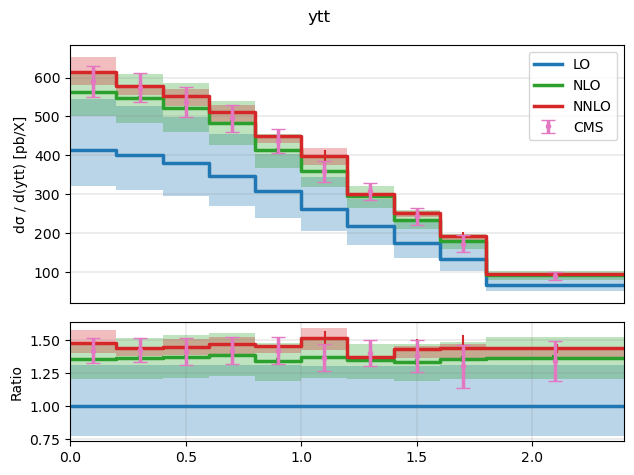

In [15]:
plot(hightea_ytt_LO,hightea_ytt_NLO,hightea_ytt_NNLO,CMS_ytt,ratio=0,logscale=False);

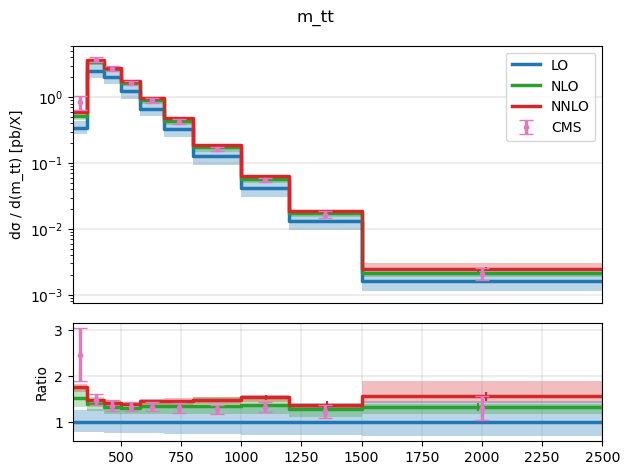

In [16]:
plot(hightea_mtt_LO,hightea_mtt_NLO,hightea_mtt_NNLO,CMS_mtt,ratio=0,logscale=True);

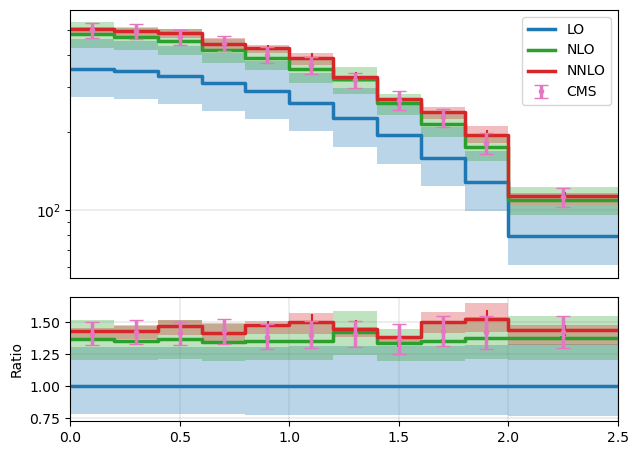

In [17]:
plot(hightea_yt_LO,hightea_yt_NLO,hightea_yt_NNLO,CMS_yt,ratio=0,logscale=True);

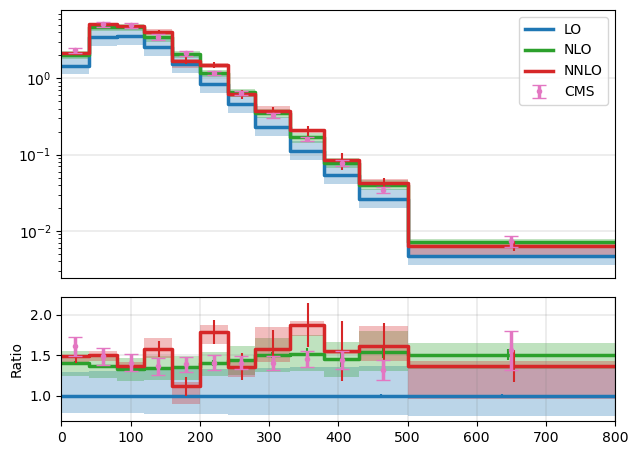

In [18]:
plot(hightea_pTt_LO,hightea_pTt_NLO,hightea_pTt_NNLO,CMS_pTt,ratio=0,logscale=True);